# prepare

## git clone

In [1]:
!git clone https://github.com/kc71486/autonomous_hw2.git
%cd autonomous_hw2

Cloning into 'autonomous_hw2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 89 (delta 1), reused 10 (delta 1), pack-reused 78
Unpacking objects: 100% (89/89), 113.87 MiB | 7.36 MiB/s, done.
/content/autonomous_hw2


## pip install

In [2]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=3a423da06527806a2672487bbf97303bd229c3fe4d6d0adf1a5a107fa46af29c
  Stored in directory: /root/.cache/pip/wheels/1d/57/24/4eff6a03a9ea0e647568e8a5a0546cdf957e3cf005372c0245
Successfully built ffmpeg


# main

## import

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import linalg
import cv2

import math
import os

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## helper functions

In [130]:
def get_point_line_dist(line, point):
    p1 = np.array(line[0]);
    p2 = np.array(line[1]);
    p3 = np.array(point);
    return abs(np.cross(p2-p1,p3-p1)/linalg.norm(p2-p1));

def scalewidth(img, beforescale):
    return int(beforescale*(img.shape[0]/1000.0))

def ratio_to_coord(img, ratio=[0, 0]):
    xsize = img.shape[1];
    ysize = img.shape[0];
    return [int(xsize*ratio[0]), int(ysize*ratio[1])];

def rgbscale(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img);
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count;
    else:
        ignore_mask_color = 255;
        
    #filling pixels inside the polygon defined by "vertices" with the fill color  
    # added [] in vertices  
    cv2.fillPoly(mask, vertices, ignore_mask_color);
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask);
    return masked_image

def hough_first_stage(img, rho, theta, threshold, min_line_len, max_line_gap,
                      thickness=2, minslope=1,
                      center=[500,500], maxoffcenter=10000):
    
    #accept 1 channel, output 1 channel (len(img.shape) == 2)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap);
    line_img = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8);
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x1 != x2):
                slope =  (y1 - y2)/(x1 - x2);
                if(abs(slope) < minslope):
                    continue;
            if(get_point_line_dist([[x1, y1], [x2, y2]], center) > maxoffcenter):
                continue;
            cv2.line(line_img, (x1, y1), (x2, y2), [255], thickness);
    return line_img;

def hough_second_stage(img, rho, theta, threshold, min_line_len, max_line_gap, 
                       thickness=2, minslope=1,
                       center=[500,500], maxoffcenter=10000):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap);
    xsize = img.shape[1];
    ysize = img.shape[0];
    line_img = np.zeros((ysize, xsize, 1), dtype=np.uint8);
    if lines is None:
        return line_img;
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x1 != x2):
                slope =  (y1 - y2)/(x1 - x2);
                if(abs(slope) < minslope):
                    continue;
                if(get_point_line_dist([[x1, y1], [x2, y2]], center) > maxoffcenter):
                    continue;
                xnorm = (x1 + x2) / 2
                xdiff = (x1 - x2) / 2
                ynorm = (y1 + y2) / 2
                ydiff = (y1 - y2) / 2
                x1 = int(xnorm +  xdiff*4)
                x2 = int(xnorm -  xdiff*4)
                y1 = int(ynorm +  ydiff*4)
                y2 = int(ynorm -  ydiff*4)
                cv2.line(line_img, (x1, y1), (x2, y2), [255], thickness);
    return line_img;

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

## lane finding algirithm

In [155]:

def process_image(img, finalstage=True):
    #some of them is 0~1, not in this video
    if(img[0][0][0] > 0 and img[0][0][0] < 1):
        img = np.uint8(img * 255);
    
    #use highest contrast while also high accuracy
    adjimg = np.empty((img.shape[0], img.shape[1], img.shape[2]), dtype=np.uint8);
    adjimg[:, :, 0] = np.copy(img[:, :, 0]);
    adjimg[:, :, 1] = np.copy(img[:, :, 1]);
    adjimg[:, :, 2] = np.copy(img[:, :, 2]);

    #some is rgba, not in this video
    if(img.shape[2] == 4):
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        grayimg = cv2.cvtColor(adjimg, cv2.COLOR_RGBA2GRAY)
    else:
        grayimg = cv2.cvtColor(adjimg, cv2.COLOR_RGB2GRAY)
    detectstrength = 0;
    while detectstrength <= 4:
        blur_gray = gaussian_blur(grayimg, 3);
        low_threshold = 35 - detectstrength*3;
        high_threshold = 90;
        edges = canny(blur_gray, low_threshold, high_threshold);
        
        left = ratio_to_coord(img, [0.0, 0.9]);
        right = ratio_to_coord(img, [1.0, 0.9]);
        left_bottom = ratio_to_coord(img, [0.0, 1.0]);
        right_bottom = ratio_to_coord(img, [1.0, 1.0]);
        left_top = ratio_to_coord(img, [0.4, 0.6]);
        right_top = ratio_to_coord(img, [0.6, 0.6]);
        vertices = np.array([[left_bottom, left, left_top, right_top, right, right_bottom]])
        masked_edges = region_of_interest(edges, vertices);
        rho = 1;
        theta = np.pi/180;
        threshold = scalewidth(img, 25 - detectstrength * 3);
        min_line_length = int(15 - detectstrength/3);
        max_line_gap = 2;
        thickness = int(1 + detectstrength/2);
        minslope = 0.4;
        center = ratio_to_coord(img, [0.5, 0.6]);
        maxoffcenter = img.shape[0]*0.05;
        line_image_first = hough_first_stage(masked_edges, rho, theta, threshold,
                                            min_line_length, max_line_gap,
                                            thickness=thickness, minslope=minslope,
                                            center=center, maxoffcenter=maxoffcenter);

        rho = 1;
        theta = np.pi/180;
        threshold = scalewidth(img, 64 - detectstrength * 10);
        min_line_length = scalewidth(img, 32 - detectstrength * 5);
        max_line_gap = scalewidth(img, 600);
        thickness = scalewidth(img, 4);
        minslope = 0.5;
        center = ratio_to_coord(img, [0.5, 0.6]);
        maxoffcenter = img.shape[0]*0.1;
        line_image_final = hough_second_stage(line_image_first, rho, theta, threshold,
                                              min_line_length, max_line_gap,
                                              thickness=thickness, minslope=minslope,
                                              center=center, maxoffcenter=maxoffcenter);
        
        left = ratio_to_coord(img, [0.0, 0.9]);
        right = ratio_to_coord(img, [1.0, 0.9]);
        left_bottom = ratio_to_coord(img, [0.0, 1.0]);
        right_bottom = ratio_to_coord(img, [1.0, 1.0]);
        left_top = ratio_to_coord(img, [0.4, 0.6]);
        right_top = ratio_to_coord(img, [0.6, 0.6]);
        vertices = np.array([[left_bottom, left, left_top, right_top, right, right_bottom]])

        if(finalstage==True):
            masked_line_image = region_of_interest(line_image_final, vertices);
        else:
            masked_line_image = region_of_interest(line_image_first, vertices);

        sumvertical = np.sum(masked_line_image, axis=0)
        validlane = sumvertical[int(img.shape[0]*0.7)] and sumvertical[int(img.shape[0]*0.3)]
        if not validlane:
            detectstrength += 1;
        else:
            break;
    colored_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8);
    colored_image[:, :, 0] = np.copy(masked_line_image);

    final_img = weighted_img(colored_image, img);
    return final_img;

## Process sample image

(1080, 1920, 4)
0.4392157


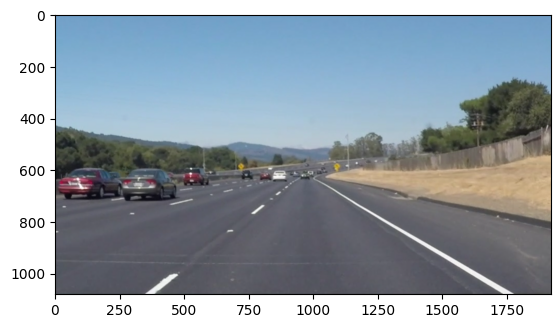

In [101]:
#reading in an image
image = mpimg.imread('test_images/issue2.png');
print(image.shape)
print(image[0][0][0])

#printing out some stats and plotting
plt.imshow(image);

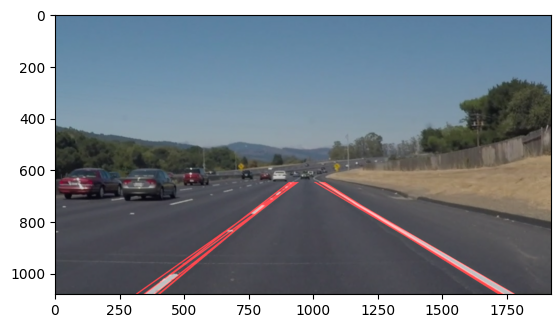

In [102]:
newimage = process_image(image, True)
plt.imshow(newimage, cmap='Greys_r')

## convert video

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   4%|▍         | 10/251 [03:46<00:17, 13.89it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4




t: 100%|██████████| 221/221 [00:24<00:00,  5.12it/s, now=None]
                                                              

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
another_output = 'test_videos_output/another.mp4'
clip1 = VideoFileClip("test_videos/another.mp4")
another_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time another_clip.write_videofile(another_output, audio=False)

In [70]:
#not supported in any of my browser though
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## git commit and push

In [142]:
#manual upload file
f = open("../remotepath.txt", "r");
remote_path = f.readline();
git_username = f.readline();
git_email = f.readline();

In [143]:
!git config --global user.email {git_email}
!git config --global user.name {git_username}
!git remote set-url origin {remote_path}

In [144]:
!git add "test_videos_output/solidWhiteRight.mp4"
!git add "test_videos_output/solidYellowLeft.mp4"
!git add "test_videos_output/challenge.mp4"
!git add "test_videos_output/another.mp4"

In [145]:
!git commit -m "add/modify videos in test_videos_output"

[main 3a6c80a] add/modify videos in test_videos_output
 4 files changed, 0 insertions(+), 0 deletions(-)
 rewrite test_videos_output/solidWhiteRight.mp4 (81%)
 rewrite test_videos_output/solidYellowLeft.mp4 (63%)


In [146]:
!git push origin main

Enumerating objects: 20, done.
Counting objects: 100% (20/20), done.
Delta compression using up to 2 threads
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 40.71 MiB | 12.50 MiB/s, done.
Total 14 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 1 local object.
To https://github.com/kc71486/autonomous_hw2.git
   3324f8c..3a6c80a  main -> main
